In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import ipas.collection_from_db.database as database
import ipas.collection_from_db.aggagg_collection as collect
from ipas.collection_from_db.calculations import ClusterCalculations
import numpy as np
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
from dask import delayed
from dask import dataframe as dd
import pickle
import glob
import pandas as pd

In [2]:
cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='10000MiB', #1 GiB = 1,024 MiB
    processes=1)

#cluster.adapt(minimum=3, maximum=20)
cluster.scale(1)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS_v1.3.0/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34957 instead
  http_address["port"], self.http_server.port


In [3]:
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://169.226.65.141:45481 Dashboard: http://169.226.65.141:34957/status,Cluster Workers: 1 Cores: 1 Memory: 9.77 GiB


## Read database

In [6]:
orientation = 'rand'  # chose which orientation (rand or flat)
if orientation == 'rand':
    rand_orient = True      #randomly orient the seed crystal and new crystal: uses first random orientation
    files = glob.glob("/network/rit/lab/sulialab/share/IPAS/ipas/instance_files/createdb_iceagg_rand*")
else:
    rand_orient = False      #randomly orient the seed crystal and new crystal: uses first random orientation
    files =  glob.glob("/network/rit/lab/sulialab/share/IPAS/ipas/instance_files/createdb_iceagg_flat*")

In [7]:
%time
db = database.Database(files)
db.read_database()
db.append_shape()
db.truncate_agg_r(5000)
db.append_agg_phi()
df = db.df  # get the dataframe (db is an instance of database.py module)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
reading:  /network/rit/lab/sulialab/share/IPAS/ipas/instance_files/createdb_iceagg_rand_r500_1000
reading:  /network/rit/lab/sulialab/share/IPAS/ipas/instance_files/createdb_iceagg_rand_r1_5
reading:  /network/rit/lab/sulialab/share/IPAS/ipas/instance_files/createdb_iceagg_rand_r6_10
reading:  /network/rit/lab/sulialab/share/IPAS/ipas/instance_files/createdb_iceagg_rand_r20_70
reading:  /network/rit/lab/sulialab/share/IPAS/ipas/instance_files/createdb_iceagg_rand_r80_400


# Main 

In [8]:
ch_dist='gamma'         #anything other than gamma uses the characteristic from the best distribution pdf (lowest SSE)
save_plots = False 
agg_phi_bins = 20
agg_r_bins = 20
nclusters = 300

In [9]:
def main():

    output = np.empty((agg_phi_bins,agg_r_bins),dtype=object)
    hold_clusters1  = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)
    hold_clusters2  = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)

    res, phi_bins = pd.qcut(df.agg_phi, agg_phi_bins, retbins=True)

    for i in range(1, agg_phi_bins):
        #print('agg phi range: ', phi_bins[i], phi_bins[i+1])
        #return a df that only queries within an aspect ratio bin
        df_phi = df[(df.agg_phi > phi_bins[i]) & (df.agg_phi < phi_bins[i+1])]  
        #to ensure at least 2 crystals within agg since ncrystals=1 not in db
        #now break that aspect ratio bin into 20 equal r bins

        res, r_bins = pd.qcut(df_phi.agg_r, agg_r_bins, retbins=True)
        for r in range(agg_r_bins):   #agg r

            #print('r = ', r_bins[r], r_bins[r+1])
            df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
            #plt.hist(df_r.mono_phi)
            #plt.xscale('log')
            #plt.show()

            samples1 = df_r.sample(nclusters)
            samples2 = df_r.sample(nclusters)

            for n, agg in enumerate(samples1.itertuples()):
                hold_clusters1[i,r,n] = ClusterCalculations(agg)
            for n, agg in enumerate(samples2.itertuples()):
                hold_clusters2[i,r,n] = ClusterCalculations(agg)
            collect.collect_clusters_agg_agg(hold_clusters1[i,r,:], hold_clusters2[i,r,:], rand_orient=rand_orient)
            #output[i,r] = dask.delayed(collect.collect_clusters_agg_agg)(hold_clusters1[i,r,:],
            #                                                     hold_clusters2[i,r,:], rand_orient=rand_orient)

    return output, hold_clusters1, hold_clusters2


In [10]:
def compute():
    agg_as = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    agg_bs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    rzs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    phi2Ds = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    cplxs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    dds = np.empty((agg_phi_bins, agg_r_bins, nclusters))

    gather = client.compute([*output.tolist()]) 
    gather = client.gather(gather)
    gather = np.array(gather)
    print(np.shape(gather))
    agg_as = gather[:,:,0,:]
    agg_bs = gather[:,:,1,:]
    agg_cs = gather[:,:,2,:]
    phi2Ds = gather[:,:,3,:]
    cplxs = gather[:,:,4,:] 
    dds = gather[:,:,5,:]

    print('DONE!')
    return agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds

made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops


/network/rit/lab/sulialab/share/IPAS/ipas/collection_from_db/calculations.py:168: RuntimeWarning: invalid value encountered in sqrt
  semimajor = np.sqrt(evals[0]) * 2


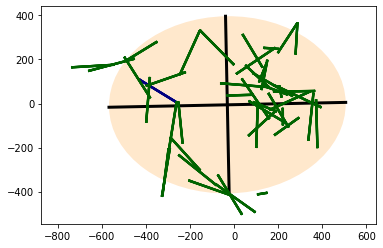

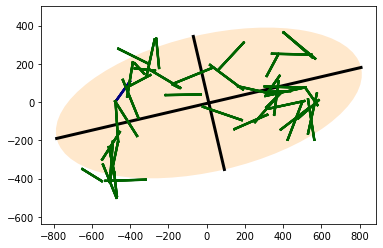

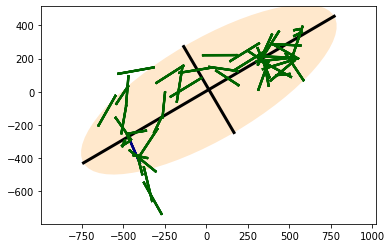

made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops
made it to the end of collect_clusters loops


KeyboardInterrupt: 

In [11]:
if __name__ == '__main__':

    output, hold_clusters1, hold_clusters2 = main()
    agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds= compute()
    results = {'agg_as': agg_as, 'agg_bs':agg_bs, 'agg_cs':agg_cs, 'phi2Ds':phi2Ds, \
               'cplxs':cplxs, 'dds':dds}


In [ ]:
# pickle data to files
filename = '../instance_files/pulled_clusters_aggagg_rand'
filehandler = open(filename, 'wb')
to_file = np.append(hold_clusters1, hold_clusters2).reshape(20,20,nclusters*2)
pickle.dump(to_file, filehandler)
filehandler.close()
print('finished!')

filename = '../instance_files/instance_db_aggagg_rand'
filehandler = open(filename, 'wb')
pickle.dump(results, filehandler)
filehandler.close()
print('finished!')

# LOAD DATA

In [ ]:
f = open('../instance_files/instance_db_aggagg_rand', 'rb')
results = pickle.load(f)
agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds= \
                results['agg_as'], results['agg_bs'], results['agg_cs'], results['phi2Ds'], results['cplxs'], results['dds']
f.close()

f = open('../instance_files/pulled_clusters_aggagg_rand', 'rb')
pulled_clus = pickle.load(f)
f.close()

In [ ]:
f = open('../instance_files/pulled_clusters_iceagg_flat', 'rb')
pulled_clus = pickle.load(f)
f.close()

In [ ]:
count=0
for phi in range(pulled_clus.shape[0]):
    for r in range(pulled_clus.shape[1]):
        for n in range(pulled_clus.shape[2]):
            if pulled_clus[phi,r,n].monophi>70.:
                count+=1
print(count/(20*20*600)*100)

In [ ]:
count=0
for phi in range(pulled_clus.shape[0]):
    for r in range(pulled_clus.shape[1]):
        for n in range(pulled_clus.shape[2]):
            if pulled_clus[phi,r,n].monophi<.1:
                count+=1
print(count/(20*20*600)*100)